In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.tabular import *
import numpy as np

In [3]:
from exp.nb_01 import load_data
from exp.nb_02 import gini_score

In [4]:
train_df, test_df = load_data(keep_df=True)

/home/vule/miniconda3/envs/thanos/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/vule/miniconda3/envs/thanos/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [5]:
train_df.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_48,FIELD_49,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57
0,0,0,NaN,NaN,NaN,NaN,NaN,1,1.0,2547.0,...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,Tỉnh Đồng Nai,Thành phố Biên Hòa,44.0,44.0,None,1,0.0,-1.0,...,False,True,29.77,17.561,30.955,31.171,0.0,0.04,0.0,0.0
2,2,0,Tỉnh Đồng Nai,Huyện Long Thành,30.0,30.0,Công nhân,0,1.0,3273.0,...,True,True,29.77,56.512,30.955,31.171,0.0,0.16,0.0,0.0
3,3,0,Tỉnh Tuyên Quang,Thành phố Tuyên Quang,43.0,NaN,NaN,0,1.0,3991.0,...,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,Thành phố Hồ Chí Minh,Quận 1,21.0,21.0,None,0,1.0,1450.0,...,True,True,29.77,13.789,30.955,31.171,0.0,0.03,0.0,0.0


In [6]:
del train_df['id']

In [7]:
dep_var = 'label'
#cat_names = data.select_dtypes(exclude=['int', 'float']).columns
cat_names = list(train_df.select_dtypes(exclude=['int', 'float']).columns)
#cont_names = data.select_dtypes([np.number]).columns
cont_names = list(train_df.select_dtypes([np.number]).columns[1:])

In [8]:
# Transformations
procs = [FillMissing, Categorify, Normalize]

In [9]:
train_df = train_df[cat_names + cont_names + [dep_var]]

In [10]:
int(len(train_df) * 0.8)

24000

In [25]:
# Test Tabular List
test = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
test_id = test_df['id']
# Train Data Bunch
data = (TabularList.from_df(train_df, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .split_by_idx(list(range(24000,30000)))
                        .label_from_df(cols = dep_var)
                        .add_test(test, label=0)
                        .databunch())

data.show_batch(rows=3)

province,district,maCv,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_17,FIELD_18,FIELD_19,FIELD_20,FIELD_23,FIELD_24,FIELD_25,FIELD_26,FIELD_27,FIELD_28,FIELD_29,FIELD_30,FIELD_31,FIELD_35,FIELD_36,FIELD_37,FIELD_38,FIELD_39,FIELD_40,FIELD_41,FIELD_42,FIELD_43,FIELD_44,FIELD_45,FIELD_47,FIELD_48,FIELD_49,age_source1_na,age_source2_na,FIELD_2_na,FIELD_3_na,FIELD_4_na,FIELD_5_na,FIELD_6_na,FIELD_16_na,FIELD_21_na,FIELD_22_na,FIELD_50_na,FIELD_51_na,FIELD_52_na,FIELD_53_na,FIELD_54_na,FIELD_55_na,FIELD_56_na,FIELD_57_na,age_source1,age_source2,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_14,FIELD_15,FIELD_16,FIELD_21,FIELD_22,FIELD_32,FIELD_33,FIELD_34,FIELD_46,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57,target
#na#,#na#,None,[],MALE,GD,T1,12,0,BI,None,True,False,False,True,None,True,False,True,True,FALSE,TRUE,FALSE,Zero,FALSE,TRUE,False,None,1,V,Zezo,None,One,1,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.1650,-0.5657,0.5377,-1.8137,-1.1822,-0.5854,-0.8886,-0.3145,-0.8149,-0.8101,-0.2477,-0.0061,-0.7455,-0.7163,-1.4673,-0.9138,1.2199,-0.3003,-1.1290,-0.2454,-0.2354,-0.2564,-0.9207,-0.2145,-0.2078,0
#na#,#na#,None,[],MALE,TN,T1,5,None,BO,G8,True,True,True,True,None,True,False,True,True,None,None,None,Two,FALSE,True,False,VN,None,II,Zezo,None,One,1,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.1650,-1.0954,0.5377,0.5513,0.8048,-0.5854,-0.8886,-0.3145,-0.8149,-0.8101,-0.2477,-0.0061,-0.7455,-0.7163,-1.4673,1.0942,-0.8197,-0.3003,-0.1618,-0.2454,-0.2354,-0.2564,-0.2180,-0.2145,-0.2078,0
#na#,#na#,#na#,[],#na#,na,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,True,True,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,-0.1650,-0.1685,-1.8597,-1.8137,-1.1822,-0.5854,-0.8886,-0.3145,1.2271,1.2343,-0.2477,-0.0061,-0.2612,1.3960,0.6815,1.0942,-0.8197,-0.3003,-0.0022,-0.2454,-0.2354,-0.2564,0.0631,-0.2145,-0.2078,0


In [12]:
# Create deep learning model
learn = tabular_learner(data, layers=[1000, 200, 15], metrics=accuracy, emb_drop=0.1, callback_fns=ShowGraph)

In [13]:
# select the appropriate learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


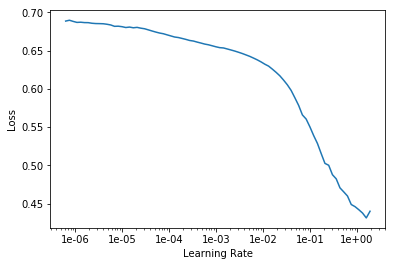

In [14]:
# we typically find the point where the slope is steepest
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.085861,0.087874,0.982833,00:12
1,0.085035,0.086602,0.982833,00:12
2,0.075347,0.091469,0.982500,00:12


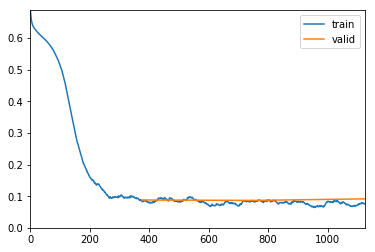

In [15]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(3, max_lr=slice(1e-02))

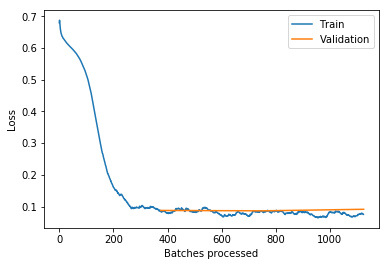

In [16]:
# Analyse our model
learn.model
learn.recorder.plot_losses()

In [17]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Valid)
y_score = predictions[:,1].tolist()
labels = np.argmax(predictions, 1)
y_valid = list(train_df[24000:30000].label)
gini_score(y_valid, y_score)

In [21]:
test_id

NameError: name 'test_id' is not defined

In [ ]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Test)
# labels = np.argmax(predictions, 1)
labels = predictions[:,1].tolist()
# create submission file to submit in Kaggle competition
submission = pd.DataFrame({'id': test_id, 'label': labels})
submission.to_csv('submission.csv', index=False)
submission.head()